In [16]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter as cnt
import string
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.metrics.pairwise import linear_kernel
from preprocess import preprocessing
import csv
import matplotlib.pyplot as plt
import pickle


In [2]:
all_dev=((pd.read_csv('data/devSet.csv')).dropna())
all_dev.shape

(388798, 6)

In [3]:
train=all_dev.sample(frac=0.95, replace=False, random_state=1)

In [4]:
dev=(all_dev[~all_dev.isin(train)].dropna())

In [5]:
train.shape, dev.shape

((369358, 6), (19440, 6))

In [6]:
def create_model(train=''):
    l_q1=list(train.question1)
    l_q2=list(train.question2)
    l_words=l_q1+l_q2

    # Preprocess text
    pre = preprocessing()
    prep_words=[pre.the_works(text=q) for q in l_words]
    
    # Join tokens per question (That's how the 
    # td-idf vectorizer works)
    joined_words=[" ".join(q) for q in prep_words]
    # Buld Model]
    
    # create word counts first and TF
    cv=CountVectorizer(lowercase=False)
    # this steps generates word counts for the words
    word_count_vector=cv.fit_transform(joined_words)
    
    # Now let's generate IDF values
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    # Visualize in dataframe the vector
    #df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
    # sort ascending
    #return df_idf.sort_values(by=['idf_weights'])
    
    # Compute TF-IDF
    # count matrix
    count_vector=cv.transform(joined_words)
 
    # tf-idf scores
    tf_idf_vector=tfidf_transformer.transform(count_vector)
    
    return cv, tfidf_transformer

In [7]:
def evaluate(threshold=0.0, test='', cv='', tfidf_transformer=''):
    global results_test
    tl_q1=list(test.question1)
    tl_q2=list(test.question2)
    dup = list(test.is_duplicate)
    pre = preprocessing()
    correct=0
    total=0
    for l_q1, l_q2,is_dup in zip(tl_q1, tl_q2, dup):
        
        # Preprocess text
        prep_q1=pre.the_works(text=l_q1)
        prep_q2=pre.the_works(text=l_q2)
        # Validation, after removal of
        # stop words, we can get into a situation
        # of having an empty string
        if prep_q1 is np.nan: continue
        if prep_q2 is np.nan: continue
        if len(prep_q1) == 0: continue
        if len(prep_q2) == 0: continue
        joined_q1 = " ".join(prep_q1)
        joined_q2 = " ".join(prep_q2)

        total=total+1
        count_vector1=cv.transform([joined_q1])
        count_vector2=cv.transform([joined_q2])
        # tf-idf scores
        final_vector1=tfidf_transformer.transform(count_vector1)
        final_vector2=tfidf_transformer.transform(count_vector2)


        cosine_similarities = linear_kernel(final_vector1[0], final_vector2[0]).flatten()
        print(cosine_similarities[0])
        if cosine_similarities[0] > threshold:
            #results_test.append((id, 1))
            correct=correct+1
        #else:
            #results_test.append((id, 0))
            
        feature_names = cv.get_feature_names()
 
        #get tfidf vector for first document
        first_document_vector=final_vector1[0]
 
        #print the scores
        df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
        df.sort_values(by=["tfidf"],ascending=False)[0:4]
    return correct/total, threshold

In [13]:
def quick_eval(threshold=0.0, test='', cv='', tfidf_transformer=''):
    global results_test
    p_q1=[]
    p_q2=[]
    tl_q1=list(test.question1)
    tl_q2=list(test.question2)
    dup = list(test.is_duplicate)
    pre = preprocessing()
    correct=0
    total=0
    tp=0
    tn=0
    fp=0
    fn=0
    for l_q1, l_q2,is_dup in zip(tl_q1, tl_q2, dup):
        
        # Preprocess text
        prep_q1=pre.the_works(text=l_q1)
        prep_q2=pre.the_works(text=l_q2)
        # Validation, after removal of
        # stop words, we can get into a situation
        # of having an empty string
        #if prep_q1 is np.nan: continue
        #if prep_q2 is np.nan: continue
        #if len(prep_q1) == 0: continue
        #if len(prep_q2) == 0: continue
        joined_q1 = " ".join(prep_q1)
        joined_q2 = " ".join(prep_q2)
        p_q1.append(joined_q1)
        p_q2.append(joined_q2)
    count_vector1=cv.transform(p_q1)
    count_vector2=cv.transform(p_q2)
    # tf-idf scores
    final_vector1=tfidf_transformer.transform(count_vector1)
    final_vector2=tfidf_transformer.transform(count_vector2)
    cosine_similarities = linear_kernel(final_vector1, final_vector2).flatten()
    total=0
    correct=0
    len_q=len(tl_q1)
    for i in list(range(0, len_q)):
        total=total+1
        cosine_similarities = linear_kernel(final_vector1[i], final_vector2[i]).flatten()
        if cosine_similarities[0] > threshold:
            if dup[i]==1:
                tp=tp+1
            else:
                fp=fp+1
        else:
            if dup[i]==0:
                tn=tn+1
            else:
                fn=fn+1
    return tp/len_q, tn/len_q, fp/len_q, fn/len_q, threshold


In [40]:
def quick_submission(threshold=0.0, test='', cv='', tfidf_transformer=''):
    global results_submitt
    p_q1=[]
    p_q2=[]
    tl_q1=list(test.question1)
    tl_q2=list(test.question2)
    tl_id=list(test.id)
    pre = preprocessing()
    for l_q1, l_q2 in zip(tl_q1, tl_q2):
        if l_q1 is np.nan: l_q1=''
        if l_q2 is np.nan: l_q2=''
        #if len(prep_q1) == 0: continue
        #if len(prep_q2) == 0: continue
        
        # Preprocess text
        #print(l_q1)
        #print(l_q2)
        #print('ll')
        prep_q1=pre.the_works(text=l_q1)
        prep_q2=pre.the_works(text=l_q2)
        # Validation, after removal of
        # stop words, we can get into a situation
        # of having an empty string
        #if prep_q1 is np.nan: continue
        #if prep_q2 is np.nan: continue
        #if len(prep_q1) == 0: continue
        #if len(prep_q2) == 0: continue
        joined_q1 = " ".join(prep_q1)
        joined_q2 = " ".join(prep_q2)
        p_q1.append(joined_q1)
        p_q2.append(joined_q2)
    count_vector1=cv.transform(p_q1)
    count_vector2=cv.transform(p_q2)
    # tf-idf scores
    final_vector1=tfidf_transformer.transform(count_vector1)
    final_vector2=tfidf_transformer.transform(count_vector2)
    cosine_similarities = linear_kernel(final_vector1, final_vector2).flatten()
    len_q=len(tl_q1)
    for i in list(range(0, len_q)):
        cosine_similarities = linear_kernel(final_vector1[i], final_vector2[i]).flatten()
        if cosine_similarities[0] > threshold:
            results_test.append((tl_id[i], 1))
        else:
            results_test.append((tl_id[i], 0))
    return None


In [9]:
cv, tfidf_transformer=create_model(train=train)

In [17]:
pickle.dump( cv, open( "model_cv.p", "wb" ) )

In [18]:
pickle.dump( tfidf_transformer, open( "model_tfidf_transformer.p", "wb" ) )

In [26]:
samples = np.linspace(.0, 1, num=20)
eval_thres=[]
tpa=[]
tna=[]
fpa=[]
fna=[]
x=[]
for i,t in enumerate(samples):
    print(i)
    results_test = []
    #prec, thres = evaluate(threshold=t, test=dev, cv=cv, tfidf_transformer=tfidf_transformer)
    tp,tn,fp,fn,threshold=quick_eval(threshold=t, test=dev, cv=cv, tfidf_transformer=tfidf_transformer)
    tpa.append(tp)
    tna.append(tn)
    fpa.append(fp)
    fna.append(fn)
    x.append(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


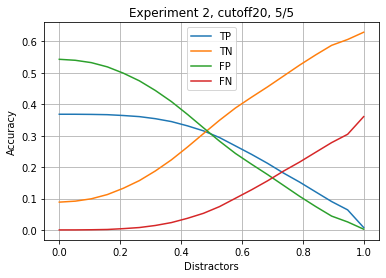

In [27]:
#fig, ax = plt.subplots(figsize=(8, 6), dpi=600)
fig, ax = plt.subplots()
ax.plot(x,tpa, label='TP')
ax.plot(x,tna,label='TN')
ax.plot(x,fpa,label='FP')
ax.plot(x,fna,label='FN')

ax.set(xlabel='Distractors', ylabel='Accuracy',
title='Experiment 2, cutoff20, 5/5')
ax.legend()
#ax.set_ylim([0,1])
#ax.xaxis.set_ticks(np.arange(0, 20, 1))
ax.grid(True, zorder=5)
#fig.savefig("results/exp2.png")

In [28]:
a_precision=[]
a_recall=[]
a_accuracy=[]
a_balance_accuracy=[]
a_f1=[]
for tp, tn, fp, fn in zip(tpa, tna, fpa, fna):
    precision=((tp)/(tp+fp))
    a_precision.append(precision)
    recall=((tp)/(tp+fn))
    a_recall.append(recall)
    accuracy=(tp+tn)/(tp+tn+fp+fn)
    a_accuracy.append(accuracy)
    
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    balance_accuracy=(tpr+tnr)/2
    a_balance_accuracy.append(balance_accuracy)
    
    f1=2*((precision*recall)/(precision+recall))
    a_f1.append(f1)

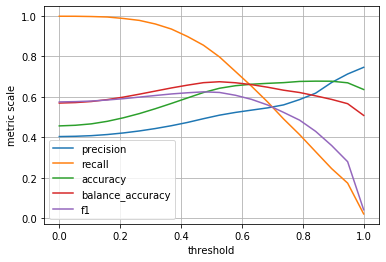

In [29]:
fig, ax = plt.subplots()
ax.plot(x,a_precision, label='precision')
ax.plot(x,a_recall,label='recall')
ax.plot(x,a_accuracy,label='accuracy')
ax.plot(x,a_balance_accuracy,label='balance_accuracy')
ax.plot(x,a_f1,label='f1')


ax.set(xlabel='threshold', ylabel='metric scale')
title='p1'
ax.legend()

#ax.set_ylim([0,1])
#ax.xaxis.set_ticks(np.arange(0, 20, 1))
ax.grid(True, zorder=5)
#fig.savefig("results/exp2.png")

In [30]:
test=pd.read_csv('data/test.csv')

In [49]:
results_test=[]
quick_submission(threshold=.75, test=test, cv=cv, tfidf_transformer=tfidf_transformer)

In [51]:
result_np=np.array(results_test)
pd.DataFrame(result_np).to_csv("test75_v2.csv",header=['id', 'is_duplicate'],index=False)